### Session 0.0: Load packages and customised functions

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
## a useful function to generate a data list for further analysis
import os,json,sys,itertools
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from locustvr_converter import preprocess_matrex_data
from behavioural_classification import classify_heading_direction
from trajectory_analysis import *
##need to add this additional cell because useful tools are in another folder. Need to integrate these two folders one day
current_working_directory = Path.cwd()
parent_dir = current_working_directory.resolve().parents[0]
sys.path.insert(0, str(parent_dir) + "\\utilities")
from useful_tools import select_animals_gpt,find_file,read_seq_config
from data_cleaning import findLongestConseqSubseq,interp_fill

#### Session 0.1: Load analysis methods in python dictionary form

In [12]:
json_file = "./analysis_methods_dictionary.json"
with open(json_file, "r") as f:
    analysis_methods = json.loads(f.read())
    

#Put the folder of your Unity experiment below
#thisDataset ="D:/MatrexVR_Swarm_Data/RunData"
#thisDataset ="D:/MatrexVR_blackbackground_Data/RunData"
#thisDataset ="D:/MatrexVR_grass1_Data/RunData"
#thisDataset ="D:/MatrexVR_navigation_Data/RunData"
thisDataset ="D:/MatrexVR_2024_Data/RunData"
#parameter name means independent variable in the experiment
#variable_name='kappa' 
#variable_name='mu'
variable_name='location'
#variable_name='initial_position'
#variable_name='agent_speed'

#### Session 0.2: Load animals' experiment directory into a list

In [ ]:
## this cell searches for a folder with csv files, usually that is the folder saving the tracking data.
## Since data from the 4 VRs are saved in the same folder, this command will return that one folder for the 4 experiment
dir_list = []
file_type=".csv"
for root, dirs, files in os.walk(thisDataset):
    for folder in dirs:
        folder_path=os.path.join(root,folder)
        if any(name.endswith(file_type) for name in os.listdir(folder_path)):
            dir_list.append(folder_path.replace("\\", "/"))

print(f"these directories are found {dir_list}")

In [ ]:
dir_list=dir_list[110:-7]

In [ ]:
dir_list

#### Session 0.3: pass temperature information into each folder

In [ ]:
##This cell is used to move data of the thermo-humidity logger to animals'folder
import shutil
#tmp_file_name='matrexVR240824-240901.txt'
#tmp_file_name='DL220THP_Thermo2_241012_241014.csv'
tmp_file_name='DL220THP_Thermo3_250618.csv'
tmp_source=os.path.join('Z:/Users/chiyu',tmp_file_name)
for this_dir in dir_list:
    tmp_new_dir = os.path.join(this_dir,tmp_file_name)
    if os.path.isfile(tmp_new_dir):
        print("Found EL USB temperature file in the new directory already")
    else:
        shutil.copy(tmp_source, tmp_new_dir)

### Session 1.0: Create curated dataset based on a list of experiment directories

In [ ]:
#This function receives directory path that contains the 4-VR data and save the tracking + stimulus information as h5 file
pattern="VR*.h5"
#pattern="VR*.parquet"
for this_dir in dir_list:
    if "archive" in this_dir:
        print(f"skip archive folder for {this_dir}")
        continue
    if any(Path(this_dir).glob(pattern)) and analysis_methods.get("overwrite_curated_dataset")==False:
        print(f"curated matrexvr h5 database found in {this_dir}. Skip this file")
        continue
    else:
        print(f"no curated matrexvr h5 database in {this_dir}. Create curated file")
        preprocess_matrex_data(this_dir,analysis_methods)

### Session 2.0: analyse animal's trajectory

#### Session 2.1: select animal based on condition and return which a directory list and a list of vr rig number to specify which animal to analyse

In [13]:
# build up dir_list of animals based on condition.
dir_list = []
file_type=".h5"
using_google_sheet=True
sheet_name = "Unity_MatrexVR"
scene_name=analysis_methods.get("experiment_name")
if analysis_methods.get("load_individual_data") == True:
    if using_google_sheet==True:
        database_id = "1UL4eEUrQMapx9xz11-IyOSlPBcep1I9vBJ2uGgVudb8"
                #https://docs.google.com/spreadsheets/d/1UL4eEUrQMapx9xz11-IyOSlPBcep1I9vBJ2uGgVudb8/edit?usp=sharing
        url = f"https://docs.google.com/spreadsheets/d/{database_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
        #df = pd.read_excel(url, engine='openpyxl')## use this function if the file is not google sheet but uploaded excel file
        df = pd.read_csv(url)
    else:
        excel_file_path = "Z:/DATA/experiment_trackball_Optomotor/Locusts Management.xlsx"
        print(f"using a database {excel_file_path} from the server but this file might be outdated")
        # Create a 'with' statement to open and read the Excel file
        with pd.ExcelFile(excel_file_path) as xls:
            # Read the Excel sheet into a DataFrame with the sheet name (folder name)
            df = pd.read_excel(xls, sheet_name)
        ##list up the conditions and answers as strings for input argument to select animal. One condition must pair with one answer
    if analysis_methods.get("select_animals_by_condition") == True:
       #animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)","gregarious_leader_grass","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
       #animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)","gregarious_leader_black")
        #animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)",variable_name,"Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        #animal_of_interest=select_animals_gpt(df,"Independent variable1",variable_name,"Independent variable2","bifuration_vr_locust_sta_black_locust","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        animal_of_interest=select_animals_gpt(df,"Independent variable2","marching_band_black_vs_leader_locust_animated_vs_inanimated","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        #animal_of_interest=select_animals_gpt(df,"Independent variable2","marching_band_black_vs_leader_locust_constant_speed&distance","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        #animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)",variable_name)
    else:
        animal_of_interest=df
    folder_name=animal_of_interest["folder name"].values
    dir_tile=np.tile(thisDataset, (len(folder_name), 1))
    vr_no=animal_of_interest["VR number"].values
    vr_no = vr_no.astype('int')
    no_food=animal_of_interest["Food retriction (-1 or the number of hours)"].values
    no_food = no_food.astype('int')
    dir_list = [''.join([x[0], '/', y]) for x,y in zip(dir_tile,folder_name)]
    dir_dict = zip(dir_list, vr_no.tolist())
else:
    for root, dirs, files in os.walk(thisDataset):
        for folder in dirs:
            folder_path=os.path.join(root,folder)
            if any(name.endswith(file_type) for name in os.listdir(folder_path)):
                dir_list.append(folder_path.replace("\\", "/"))

In [ ]:
dir_list=dir_list[17:]
vr_no=vr_no[17:]

#### Session 2.2: load hdf files and sequence config of those animals and create a common index between each others

In [15]:
trial_evaluation_list=[]
raster_list=[]
seq_config_list=[]
animal_id=0
for this_dir,this_vr in zip(dir_list,vr_no):
    if analysis_methods.get("time_series_analysis")==True:
        summary_pattern = f"VR{this_vr}*score_full.h5"
        xy_pattern = f"VR{this_vr}*XY_full.h5"
    else:
        summary_pattern = f"VR{this_vr}*score.h5"
        xy_pattern = f"VR{this_vr}*XY.h5"
    found_result = find_file(Path(this_dir), summary_pattern)     
    trial_evaluation = pd.read_hdf(found_result)
    trial_evaluation['VR'] = np.tile(f"VR{this_vr}", (len(trial_evaluation), 1))
    trial_evaluation['VR'] =trial_evaluation["VR"]+"_"+trial_evaluation["fname"]
    trial_evaluation.insert(0, 'animal_id',np.repeat(animal_id,trial_evaluation.shape[0]))
    trial_evaluation_list.append(trial_evaluation)
    found_result = find_file(Path(this_dir), xy_pattern)        
    dfxy = pd.read_hdf(found_result)
    dfxy['VR'] = np.tile(f"VR{this_vr}", (len(dfxy), 1))
    dfxy['VR'] =dfxy["VR"]+"_"+dfxy["fname"]
    dfxy.insert(0, 'animal_id',np.repeat(animal_id,dfxy.shape[0]))
    raster_list.append(dfxy)
    seq_config_pattern=f"*sequenceConfig.json"
    seq_config_file=find_file(Path(this_dir), seq_config_pattern)
    seq_config_pd=read_seq_config(seq_config_file)
    seq_config_pd['VR']=trial_evaluation['VR'].values
    seq_config_pd.insert(0, 'step_id',np.arange(seq_config_pd.shape[0]))
    seq_config_pd.insert(0, 'animal_id',np.repeat(animal_id,seq_config_pd.shape[0]))
    seq_config_list.append(seq_config_pd)
    animal_id +=1

#### Session 2.2.1: concatenate animal's data from the list into a big pandas dataframe

In [16]:
trial_evaluation_all=pd.concat(trial_evaluation_list)
seq_config_all=pd.concat(seq_config_list)
raster_all=pd.concat(raster_list)

#### Session 2.2.1.5: check each animal's walking distance durning ISI

In [9]:
trial_evaluation_all[['VR_num', 'Date','Time']] = trial_evaluation_all['VR'].str.split('_', expand=True)
trial_evaluation_ISI=trial_evaluation_all[trial_evaluation_all['density']==0]
ISI_evaluation_aba = trial_evaluation_ISI.groupby('animal_id').agg(
    travel_distance=('distTotal', 'mean'),
    vr_no=('VR_num', 'first'),
)

In [ ]:
sns.histplot(data=ISI_evaluation_aba, x="travel_distance")
plt.show()

#### Session 2.2.2: select active moving trials for plotting only or include all the trials with good tracking

In [17]:
body_length=analysis_methods.get("body_length")  # Default body length if not specified
good_tracking=trial_evaluation_all['loss']< 0.05
active_trials=(good_tracking) & (trial_evaluation_all["distTotal"]>body_length*6)
# 6 body length seems to reduce enough autocorrelation of heading direction based on https://github.com/jgraving/sayin_locust_mixture_model/blob/main/locust_mixture_model.ipynb
if analysis_methods.get("active_trials_only"):
    trial_evaluation_interest=trial_evaluation_all[active_trials]
else:
    trial_evaluation_interest=trial_evaluation_all[good_tracking]

#### Session 2.2.3: plot the distribution of the heading angle along x (cos) or y (sin) axis, histogram of heading direction, walking distance

In [ ]:
plot_individual_data=False
for key,grp  in seq_config_all.groupby('configFile'):
    print(f"analyse {key}")
    this_evaluation=trial_evaluation_interest.loc[trial_evaluation_interest['VR'].isin(grp['VR'])]
    if plot_individual_data:
        for this_animal_id, this_animal_data in this_evaluation.groupby('animal_id'):
            plot_sercansincos(this_animal_data,analysis_methods,key.split(".")[0],'trial',vr_num=this_animal_id)
            plot_travel_histrogram(this_animal_data,analysis_methods,key.split(".")[0],'trial',vr_num=this_animal_id)
            plot_circular_histrogram(this_animal_data,analysis_methods,key.split(".")[0],'trial',vr_num=this_animal_id)

    else:
        plot_sercansincos(this_evaluation,analysis_methods,key.split(".")[0],'trial')
        plot_travel_histrogram(this_evaluation,analysis_methods,key.split(".")[0],'trial')
        plot_circular_histrogram(this_evaluation,analysis_methods,key.split(".")[0],'trial')

#### Session 2.2.4: plot animal's trajectory across trials (can choose whether to plot individual animal's trajectory or all animal's trajectory in the same plot)

In [ ]:
plot_individual_data=False
for key,grp  in seq_config_all.groupby('configFile'):
    print(f"analyse {key}")
    df_trials=raster_all.loc[raster_all['VR'].isin(grp['VR']) & (raster_all['VR'].isin(trial_evaluation_interest['VR']))]
    if plot_individual_data:
        for this_animal_id, this_animal_data in df_trials.groupby('animal_id'):
            plot_sercantrajec(this_animal_data,analysis_methods,key.split(".")[0],'trial',trajec_lim=300,vr_num=this_animal_id)
    else:
        plot_sercantrajec(df_trials,analysis_methods,key.split(".")[0],'trial',trajec_lim=300,vr_num='all')

#### Session 2.2.5: do further analysis on the animal's choice trial by trial

In [18]:
left_right_preference_all=[]
oi_preference_all=[]
pi_preference_all=[]
labels_all=[]
for this_animal_id,this_animal_data in trial_evaluation_interest.groupby('animal_id'):
    left_right_preference_this_animal=[]
    oi_preference_this_animal=[]
    pi_preference_this_animal=[]
    labels_this_animal=[]
    for this_fname,this_data in this_animal_data.groupby('fname'):
        this_trial=raster_all.loc[raster_all['VR'].values==this_data['VR'].values]    
        labels,oi,pi,pi_follow_of_only,left_right_preference=classify_heading_direction(this_trial['heading'].values,0)
        left_right_preference_this_animal.append(left_right_preference)
        oi_preference_this_animal.append(oi)
        pi_preference_this_animal.append(pi_follow_of_only)
        labels_this_animal.append(labels)
    left_right_preference_all.append(left_right_preference_this_animal)
    oi_preference_all.append(oi_preference_this_animal)
    pi_preference_all.append(pi_preference_this_animal)
    labels_all.append(labels_this_animal)
trial_evaluation_interest.insert(0, 'left_right_preference', np.hstack(left_right_preference_all))
trial_evaluation_interest.insert(0, 'optic_flow_preference',np.hstack(oi_preference_all))
trial_evaluation_interest.insert(0, 'directional_cues_preference', np.hstack(pi_preference_all))

#### Session 2.2.5.1: plot the preference trial by trial

In [ ]:
plot_individual_data=True
for key,grp  in seq_config_all.groupby('configFile'):
    print(f"analyse {key}")
    this_evaluation=trial_evaluation_interest.loc[trial_evaluation_interest['VR'].isin(grp['VR'])]
    if plot_individual_data:
        for this_animal_id, this_animal_data in this_evaluation.groupby('animal_id'):
            sns.jointplot(data=this_animal_data.reset_index(drop=True), x="left_right_preference", y="directional_cues_preference")
    else:
        sns.jointplot(data=this_evaluation.reset_index(drop=True), x="left_right_preference", y="directional_cues_preference")

#### Session 2.2.5.2: a quick way to plot left right preference animal by animal

In [ ]:
plot_individual_data=True
left_right_preference_all=[]
conditions_this_analysis=[]
for key,grp  in seq_config_all.groupby('configFile'):
    print(f"analyse {key}")
    df_trials=raster_all.loc[raster_all['VR'].isin(grp['VR']) & (raster_all['VR'].isin(trial_evaluation_interest['VR']))]
    if plot_individual_data:
        left_right_preference_this_condition=[]
        for this_animal_id, this_animal_data in df_trials.groupby('animal_id'):
            l,oi,pi,pi_follow_of_only,left_right_preference=classify_heading_direction(this_animal_data['heading'].values,0)
            left_right_preference_this_condition.append(left_right_preference)
        left_right_preference_all.append(left_right_preference_this_condition)
        conditions_this_analysis.append(key)
    else:
        l,oi,pi,pi_follow_of_only,left_right_preference=classify_heading_direction(df_trials['heading'].values,0)
        left_right_preference_all.append(left_right_preference)
### plot individual left/right preference for each trial condition. This can be used when we not pooling data across trial condition
for left_right_preference_this_condition,sequence_config_this_condition in zip(left_right_preference_all,conditions_this_analysis):
    this_data=np.column_stack(left_right_preference_this_condition)
    data=this_data[0,:]
    plot_scatter_violin(data,sequence_config_this_condition)
plt.show()

#### Session 2.2.5.3: when plotting left right preference animal by animal across trial conditions

In [ ]:
## firstly, sort out the trial condition based on alphabetically order
trial_type_list=seq_config_all['configFile'].unique()
trial_type_list[2:]=sorted(trial_type_list[2:], key=str,reverse=True)
trial_type_list[:2]=sorted(trial_type_list[:2], key=str,reverse=True)
print(trial_type_list)

In [ ]:
## select trial type for further analysis. Note: only pick two at a time
#trial_type_of_interest=[trial_type_list[8],trial_type_list[5]]
trial_type_of_interest=[trial_type_list[5],trial_type_list[8]]

In [ ]:
plot_individual_data=True
labels_all=[]
for key,grp  in seq_config_all.groupby('configFile'):
    if key in trial_type_of_interest:
        print(f"analyse {key}")
        df_trials=raster_all.loc[raster_all['VR'].isin(grp['VR']) & (raster_all['VR'].isin(trial_evaluation_interest['VR']))]
        if plot_individual_data:
            labels_this_condition=[]
            for this_animal_id, this_animal_data in df_trials.groupby('animal_id'):
                labels,oi,pi,pi_follow_of_only,left_right_preference=classify_heading_direction(this_animal_data['heading'].values,0)
                labels_this_condition.append(labels)
            labels_all.append(labels_this_condition)
            conditions_this_analysis.append(key)
        else:
            labels,oi,pi,pi_follow_of_only,left_right_preference=classify_heading_direction(df_trials['heading'].values,0)

In [139]:
## calculate the orietnate epochs for left and right
epochs_arr=np.zeros((len(trial_type_of_interest)*2,len(labels_all[0])))
for i in range(len(trial_type_of_interest)):
    for j in range(len(labels_all[0])):
        if i==0:
            epochs_arr[i,j]=sum(labels_all[i][j]=="for_left")
            epochs_arr[i+2,j]=sum(labels_all[i][j]=="for_right")
        else:
            epochs_arr[i,j]=sum(labels_all[i][j]=="for_left")
            epochs_arr[i+2,j]=sum(labels_all[i][j]=="for_right")
## sum the epochs across trial types
epochs_for_L=epochs_arr[0,:]+epochs_arr[1,:]
epochs_for_R=epochs_arr[2,:]+epochs_arr[3,:]
## when summing the epochs for a particular agent type, we need to flip the epochs for left or right to meet the design of the experiment
if trial_type_of_interest[0].split("_x_")[1].split(".")[0]=='gregarious_animated':
    epochs_for_exp=epochs_arr[0,:]+epochs_arr[3,:]
    epochs_for_con=epochs_arr[1,:]+epochs_arr[2,:]
else:
    epochs_for_exp=epochs_arr[1,:]+epochs_arr[2,:]
    epochs_for_con=epochs_arr[0,:]+epochs_arr[3,:]
## calcualte agent preference and left right preference
agent_preference=(epochs_for_exp-epochs_for_con)/(epochs_for_exp+epochs_for_con)
left_right_preference=(epochs_for_L-epochs_for_R)/(epochs_for_L+epochs_for_R)

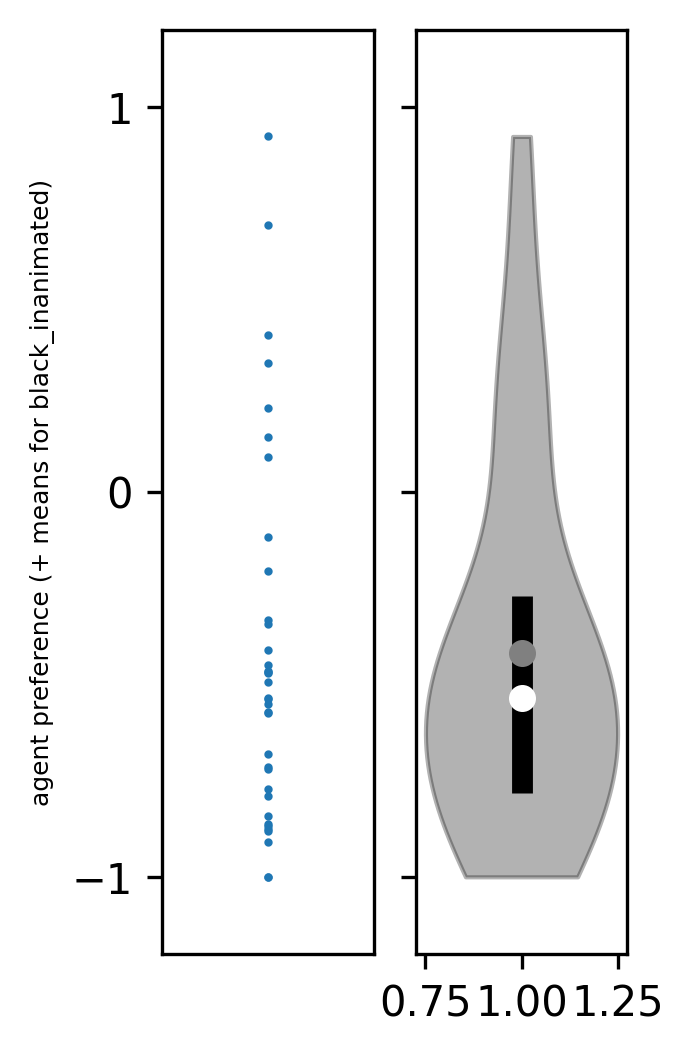

In [140]:
## plot the result
fig_parent=trial_type_of_interest[0].split(".")[0]
fig_name=f"agent_{fig_parent}"
plot_scatter_violin(agent_preference,fig_name)

#### (deprecated) Session 2.2.2: combine tables in the two lists in to 2 big tables

In [ ]:
# When using spatial discretization, information about tracking quality is not logged in the dfXY, 
# hence there is a need to pass that information from df
def connect_two_tables(dir_list,analysis_methods,test_parameter='kappa',vr_no=[]):
    scene_name=analysis_methods.get("experiment_name")
    df_all=[]
    dfxy_all=[]
    dir_iterator=[]
    if len(vr_no)>0:
        print("i am using list")
        dir_iterator=zip(dir_list,vr_no)
    elif type(dir_list)==dict:
        print("i am using dictionary")
        dir_iterator=dir_dict
    else:
        print("there is a bug")
        return df_all,dfxy_all
    for this_dir,this_vr in dir_iterator:
        if Path(this_dir).is_dir()==False:
            continue
        summary_pattern = f"VR{this_vr}*score_full.h5"
        xy_pattern = f"VR{this_vr}*XY_full.h5"
        found_result = find_file(Path(this_dir), summary_pattern)        
        df = pd.read_hdf(found_result)
        df['VR'] = np.tile(f"VR{this_vr}", (len(df), 1))
        df['VR'] =df["VR"]+"_"+df["fname"]
        #COL = MplColorHelper(colormap_name, 0, num_independent_variable)
        found_result = find_file(Path(this_dir), xy_pattern)
        dfxy = pd.read_hdf(found_result)
        dfxy['VR'] = np.tile(f"VR{this_vr}", (len(dfxy), 1))
        dfxy['VR'] =dfxy["VR"]+"_"+dfxy["fname"]
        #df.loc[(df["distTotal"]<10.0) | (df["loss"]> 0.05), "distTotal"] = np.nan
        ##hardcode color code here for scatter plot
        if test_parameter == 'kappa':
            color_code={0.1: 0.2, 1.0: 0.4, 10.0: 0.6,100000.0:1}
        elif test_parameter == 'mu':
            if scene_name.lower()=='choice':
                #color_code={0: 0.1,45: 0.4,315: 0.7}
                color_code={0: 0.1,135: 0.4,225: 0.7}
            elif scene_name.lower()=='swarm':
                color_code={0: 0.1, 45: 0.2, 90: 0.3,135:0.4,180: 0.5, 225: 0.6, 270: 0.7,315:0.8}
            elif scene_name.lower()=='band':
                color_code={0: 0.1, 45: 0.2, 90: 0.3, 270: 0.7,315:0.8}
            else:
                return Warning('scene name not found')
        elif test_parameter == 'agent_speed':
            color_code={1.0: 0.2,2.0: 0.4, 4.0: 0.6,8.0:1}
        else:
            return Warning('test parameter not found')
        df['color_code'] = df[test_parameter].map(color_code)
        df_all.append(df)
        dfxy_all.append(dfxy)
    return df_all,dfxy_all

In [ ]:
if 'vr_no' in locals():
    df_all,dfxy_all=connect_two_tables(dir_list,analysis_methods,variable_name,vr_no)
else:
    df_all,dfxy_all=connect_two_tables(dir_dict,analysis_methods,variable_name)

#### (deprecated) Session 2.3: plot animals' response during the trial with customised plotting functions.

In [ ]:
#plot responses (mean angle and travel distance) from individual experiments (usually every 4 animal an experiment; different colour mark different animals in that experiment) 
#or comparing trial by trial response through normalised response (e.g. ratio to previous trial) or scatter plot (each dot means a comparison, 
#different colour means data from different rigs, different independent variables is marked with different kappa value)
## 1st: plots with independent variables such as kappa or mu against travel distance or angle
if len(df_all)>0:
    plot_travel_distance_set(df_all,analysis_methods,variable_name,y_axis_lim=[0,12])

#### (deprecated) Session 2.3.3: combine pandas dataframe across animals and filter out trials with bad tracking (these are preprocessing steps to use Sercan's functions)

In [ ]:
#Firstly, concatenate every animal's dataframe into a big table and then sort them based on conditions.
if len(dfxy_all)>0:
    dfxy_con = pd.concat(dfxy_all)
if len(df_all)>0:
    df_con = pd.concat(df_all)
good_tracking=df_con['loss']< 0.05
active_trials=(df_con['loss'] < 0.05) & (df_con["distTotal"]>50)

In [ ]:
analysis_methods.update({"save_output": True})

#### (deprecated) Session 2.3.4: plot trial by trial trajectory

In [ ]:
#plotting trajectory
#differentiate between stim and ISI based on columns in dfxy_con
if analysis_methods.get("active_trials_only"):
    df_interest=df_con[active_trials]
else:
    df_interest=df_con[good_tracking]


if analysis_methods.get("experiment_name")=="choice":
    stim_or_isi=dfxy_con['radial_distance']
elif analysis_methods.get("experiment_name")=="swarm" or analysis_methods.get("experiment_name")=="band":
    stim_or_isi=dfxy_con['density']
df_stim=dfxy_con.loc[(dfxy_con['VR'].isin(df_interest['VR'])) & (stim_or_isi>0)]
for key, grp in df_stim.groupby([variable_name,'type']):
    print(f"{variable_name}:{key}")
    plot_sercantrajec(grp,analysis_methods,key[0],variable_name,500)
df_isi=dfxy_con.loc[(dfxy_con['VR'].isin(df_interest["VR"])) & (stim_or_isi==0)]
for key, grp in df_isi.groupby([variable_name,'type']):
#for key, grp in df_isi.groupby(variable_name):
    print(f"{variable_name}:{key}")
    plot_sercantrajec(grp,analysis_methods,key[0],variable_name,500)
#xy_lim at around 2000 is good for trial lasts around 4 or 5 min
#xy_lim at around 500 is good for trial lasts around 1 min

#### (deprecated) Session 2.3.5: pool mean angle together to make KDE plots

In [ ]:
#Visualise the distribution of mean angle at sin and cos using seaborn kernel density estimation plot
#differentiate between stim and ISI based on columns in df_con
if analysis_methods.get("active_trials_only"):
    df_interest=df_con[active_trials]
else:
    df_interest=df_con

if analysis_methods.get("experiment_name")=="choice":
    stim_or_isi=df_interest['radial_distance']
elif analysis_methods.get("experiment_name")=="swarm" or analysis_methods.get("experiment_name")=="band":
    stim_or_isi=df_interest['density']
df_stim=df_interest[stim_or_isi>0]

for key, grp in df_stim.groupby([variable_name,'type']):
    print(f"{variable_name}:{key}")
    plot_sercansincos(grp,analysis_methods,key[0],variable_name)
df_isi=df_interest[stim_or_isi==0]
for key, grp in df_isi.groupby([variable_name,'type']):
    print(f"{variable_name}:{key}")
    plot_sercansincos(grp,analysis_methods,key[0],variable_name)

In [ ]:
#Visualise the distribution of  mean angle using seaborn kernel density estimation plot
#differentiate between stim and ISI based on columns in df_con
if analysis_methods.get("active_trials_only"):
    df_interest=df_con[active_trials]
else:
    df_interest=df_con
if analysis_methods.get("experiment_name")=="choice":
    stim_or_isi=df_interest['radial_distance']
elif analysis_methods.get("experiment_name")=="swarm" or analysis_methods.get("experiment_name")=="band":
    stim_or_isi=df_interest['density']
#df_stim=df_con[stim_or_isi>0]
df_stim=df_interest[stim_or_isi>0]
for key, grp in df_stim.groupby(parameter_name):
    print(f"{parameter_name}:{key}")
    plot_travel_histrogram(grp,analysis_methods,key,parameter_name)
    #plot_circular_histrogram(grp,analysis_methods,key,parameter_name)
#df_isi=df_con[stim_or_isi==0]
df_isi=df_interest[stim_or_isi==0]
for key, grp in df_isi.groupby(parameter_name):
    print(f"{parameter_name}:{key}")
    plot_travel_histrogram(grp,analysis_methods,key,parameter_name)
    #plot_circular_histrogram(grp,analysis_methods,key,parameter_name)

#### (deprecated) Session 2.3.5: plot individual animal's trajectory

In [ ]:
dir_iterator=[]
if len(vr_no)>0:
    print("i am using list")
    dir_iterator=zip(dir_list,vr_no)
elif type(dir_list)==dict:
    print("i am using dictionary")
    dir_iterator=dir_dict
else:
    print("there is a bug")
animal_count=0
for this_dir,this_vr in dir_iterator:
    if Path(this_dir).is_dir()==False:
        #print(f'no such a dir exist {this_dir}')
        continue
    locust_pattern = f"VR{this_vr}*XY.h5"
    found_result = find_file(Path(this_dir), locust_pattern)        
    print(found_result)
    #if str(found_result).endswith('VR2_2024-10-14_134515_XY.h5'):
    if str(found_result).endswith('VR4_2024-10-13_184515_XY.h5'):
        print('use this animal as example')
        dfxy = pd.read_hdf(found_result)
        dfxy['VR'] = np.tile(f"VR{this_vr}", (len(dfxy), 1))
        dfxy['VR'] =dfxy["VR"]+"_"+dfxy["fname"]
        summary_pattern = f"VR{this_vr}*score.h5"
        found_result = find_file(Path(this_dir), summary_pattern)        
        df = pd.read_hdf(found_result)
        df['VR'] = np.tile(f"VR{this_vr}", (len(df), 1))
        df['VR'] =df["VR"]+"_"+df["fname"]
        if analysis_methods.get("experiment_name")=="choice":
            stim_or_isi=dfxy['radial_distance']
        elif analysis_methods.get("experiment_name")=="swarm" or analysis_methods.get("experiment_name")=="band":
            stim_or_isi=dfxy['density']
        df_stim=dfxy.loc[(dfxy['VR'].isin(df['VR'])) & (stim_or_isi>0)]
        for key, grp in df_stim.groupby(parameter_name):
            print(f"kappa:{key},animal_id:{animal_count}")
            plot_sercantrajec(grp,analysis_methods,key,parameter_name,300)
        df_isi=dfxy.loc[(dfxy['VR'].isin(df['VR'])) & (stim_or_isi==0)]
        for key, grp in df_isi.groupby(parameter_name):
            print(f"kappa:{key}")
            plot_sercantrajec(grp,analysis_methods,key,parameter_name,300)
        animal_count=animal_count+1
    else:
        animal_count=animal_count+1
        continue

In [ ]:
#this is used to define active animals 
travel_distance_across_animals=np.ones(len(df_all))
for id in np.arange(len(df_all)):
    this_df=df_all[id]
    travel_distance_across_animals[id]=this_df[this_df['loss']< 0.05]['distTotal'].sum()
plt.hist(travel_distance_across_animals,bins=30)
plt.show()
## if an animal dont move at all, default analysis pipeline will out put 3 body length (12 cm) per trial, hence the minimum travel distance for an experiment is 12*(trial+ISI number)

In [ ]:
#note PI and OI during ISI does not make sense 
##next step, check animals' response across stim type, across trials
save_output= analysis_methods.get("save_output")
num_example_animal=22
all_OIs=np.ones((2,len(dfxy_all)))
all_PIs=np.ones((2,len(dfxy_all)))
all_PIs_follow_only=np.ones((2,len(dfxy_all)))
all_tortuosity=np.ones((4,len(dfxy_all)))## return NaN, if animals make one or less than one move; and if inactive animals are excluded from analysis
# if analysis_methods.get("experiment_name")=="choice":
#     stim_or_isi=dfxy_con['radial_distance']
# elif analysis_methods.get("experiment_name")=="swarm" or analysis_methods.get("experiment_name")=="band":
#     stim_or_isi=dfxy_con['density']
active_animal_threshold=2500
animal_count=0
for id in np.arange(len(dfxy_all)):
    if analysis_methods.get("active_animals_only",False):
        this_animal=df_all[id]
        if this_animal[this_animal['loss']< 0.05]['distTotal'].sum()>active_animal_threshold:
            pass
        else:
            all_OIs[:,animal_count]=np.nan
            all_PIs[:,animal_count]=np.nan
            all_tortuosity[:,animal_count]=np.nan
            animal_count=animal_count+1
            continue
    else:
        pass
    optomotor_stim=[]
    preference_stim=[]
    labels_stim=[]
    optomotor_isi=[]
    preference_isi=[]
    labels_isi=[]
    tortuosity_stim=[]
    tortuosity_isi=[]
    preference_stim_follow_of=[]
    preference_isi_follow_of=[]
    trial_id=0
    for key, grp in dfxy_all[id].groupby('fname'):
        if grp['density'][0]>0 or trial_id==0:## during trial or during pre-stim background, use default mu
            this_mu=grp['mu'].unique()[0]
        else:## during ISI, continue to use mu from previous trial to check how long navigation direction persist 
            pass
        this_hdf_file=dfxy_all[id].iloc[0]['VR']
        #generate labels of classification, index for that trials
        l,oi,pi,pi_follow_of_only,_=classify_heading_direction(grp['heading'].values,this_mu)
        #calculate tortuosity
        arc=np.sqrt(np.square(np.diff(grp['X'].values)) + np.square(np.diff(grp['Y'].values)))
        chord=np.sqrt(np.square(grp['X'].values[-1]-grp['X'].values[0])+np.square(grp['Y'].values[-1]-grp['Y'].values[0]))
        if chord>0:
            this_tortuosity=np.sum(arc)/chord
        else:
            this_tortuosity=np.nan
        if grp['density'][0]>0:
            optomotor_stim.append(oi)
            preference_stim.append(pi)
            preference_stim_follow_of.append(pi_follow_of_only)
            tortuosity_stim.append((np.sum(arc),chord))
            labels_stim.append(l)
            fig_title=f'{this_hdf_file}_trial{trial_id}_stim_{this_mu}'
        else:
            optomotor_isi.append(oi)
            preference_isi.append(pi)
            preference_isi_follow_of.append(pi_follow_of_only)
            tortuosity_isi.append((np.sum(arc),chord))
            labels_isi.append(l)
            fig_title=f'{this_hdf_file}_trial{trial_id}_isi_{this_mu}'
        if analysis_methods.get("plotting_trajectory",False) and animal_count==num_example_animal:
            print(dfxy_all[id].iloc[0]['VR'],this_mu)
            if grp['heading'].shape[0]>1:
                ax = plt.subplot(111, polar=True)
                ax.hist(grp['heading'].values, bins=24, alpha=0.75)
                fig2, ax2 = plt.subplots(
                nrows=1, ncols=1, figsize=(18, 6), tight_layout=True
            )
                xy=np.column_stack((grp["X"].values,grp["Y"].values))
                seg_no=1
                for start, stop in zip(xy[:-1], xy[1:]):
                    x, y = zip(start, stop)
                    if l[seg_no]=='for_of':
                        this_color='b'
                    elif l[seg_no]=="target_ob":
                        this_color='r'
                    elif l[seg_no]=="against_of":
                        this_color='c'
                    else:
                        this_color='k'
                    ax2.plot(x, y, color=this_color,linewidth=1)
                    ax2.set(xlim=(-250,250),ylim=(-250,250),aspect=('equal'))
                    seg_no=seg_no+1
                fig2.suptitle(fig_title)
                fig2_name=fig_title+'.png'
                if save_output:
                    fig2.savefig(fig2_name)
                plt.show()

        trial_id=trial_id+1

    if analysis_methods.get("plotting_trajectory",False) and animal_count==num_example_animal:
        decision_count = np.array([these_labels.size for these_labels in labels_stim])
        alpha_values=np.ones(decision_count.size)
        alpha_values[(decision_count < 10)] = 0.2
        alpha_values[(decision_count >= 10) & (decision_count < 20)] = 0.6
        alpha_values[(decision_count >= 20) & (decision_count < 30)] = 0.8
        alpha_values[(decision_count >= 30)] = 1
        fig1, axes = plt.subplots(
            nrows=4, ncols=3, figsize=(12, 9), tight_layout=True
        )
        ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12= axes.flatten()
        ax1.hist(optomotor_stim,color='k')
        ax1.hist(optomotor_isi,alpha = 0.05,color='k',ls='dashed',lw=3)
        ax2.hist(preference_stim_follow_of,color='k')
        ax2.hist(preference_isi_follow_of,alpha = 0.05,color='k',ls='dashed',lw=3)
        ax3.hist(preference_stim,color='k')
        ax3.hist(preference_isi,alpha = 0.05,color='k',ls='dashed',lw=3)
        ax4.scatter(np.array(optomotor_isi),np.array(optomotor_stim),color='k',alpha=alpha_values)
        ax5.scatter(np.array(preference_isi_follow_of),np.array(preference_stim_follow_of),color='k',alpha=alpha_values)
        ax6.scatter(np.array(preference_isi),np.array(preference_stim),color='k',alpha=alpha_values)
        ax7.scatter(np.array(optomotor_stim)[::2],np.array(optomotor_stim)[1::2],color='k',alpha=alpha_values[1::2])
        ax8.scatter(np.array(preference_stim_follow_of)[::2],np.array(preference_stim_follow_of)[1::2],color='k',alpha=alpha_values[1::2])
        ax9.scatter(np.array(preference_stim)[::2],np.array(preference_stim)[1::2],color='k',alpha=alpha_values[1::2])
        ax10.scatter(np.array(optomotor_stim)[1:-1:2],np.array(optomotor_stim)[3::2],color='k',alpha=alpha_values[1:-1:2])
        ax11.scatter(np.array(preference_stim_follow_of)[1:-1:2],np.array(preference_stim_follow_of)[3::2],color='k',alpha=alpha_values[1:-1:2])
        ax12.scatter(np.array(preference_stim)[1:-1:2],np.array(preference_stim)[3::2],color='k',alpha=alpha_values[1:-1:2])
        ax1.set(
        xlim=(-1.2,1.2),
        xlabel='optomotor index',
        ylabel='count of decision')
        ax2.set(
        xlim=(-1.2,1.2),
        xlabel='preference index (follow of vs. target ob)',
        ylabel='count of decision')
        ax3.set(
        xlim=(-1.2,1.2),
        xlabel='preference index',
        ylabel='count of decision')
        ax4.set(
        xlabel='optomotor index ISI',
        ylabel='optomotor index following Stim',
        xlim=(-1.2,1.2),
        ylim=(-1.2,1.2),
        yticks=([-1, 0, 1]),
        xticks=([-1, 0, 1]),
        aspect=('equal'))
        ax5.set(
        xlabel='preference index (follow of vs. target ob) ISI',
        ylabel='preference index (follow of vs. target ob) following Stim',
        xlim=(-1.2,1.2),
        ylim=(-1.2,1.2),
        yticks=([-1, 0, 1]),
        xticks=([-1, 0, 1]),
        aspect=('equal'))
        ax6.set(
        xlabel='preference index ISI',
        ylabel='preference index following Stim',
        xlim=(-1.2,1.2),
        ylim=(-1.2,1.2),
        yticks=([-1, 0, 1]),
        xticks=([-1, 0, 1]),
        aspect=('equal'))
        ax7.set(
        xlabel='optomotor index Stim n',
        ylabel='optomotor index Stim n+1',
        xlim=(-1.2,1.2),
        ylim=(-1.2,1.2),
        yticks=([-1, 0, 1]),
        xticks=([-1, 0, 1]),
        aspect=('equal'))
        ax8.set(
        xlabel='preference index (follow of vs. target ob) Stim n',
        ylabel='preference index (follow of vs. target ob) Stim n+1',
        xlim=(-1.2,1.2),
        ylim=(-1.2,1.2),
        yticks=([-1, 0, 1]),
        xticks=([-1, 0, 1]),
        aspect=('equal'))
        ax9.set(
        xlabel='preference index Stim n',
        ylabel='preference index Stim n+1',
        xlim=(-1.2,1.2),
        ylim=(-1.2,1.2),
        yticks=([-1, 0, 1]),
        xticks=([-1, 0, 1]),
        aspect=('equal'))
        ax10.set(
        xlabel='optomotor index Stim n',
        ylabel='optomotor index following ISI',
        xlim=(-1.2,1.2),
        ylim=(-1.2,1.2),
        yticks=([-1, 0, 1]),
        xticks=([-1, 0, 1]),
        aspect=('equal'))
        ax11.set(
        xlabel='preference index (follow of vs. target ob) Stim n',
        ylabel='preference index (follow of vs. target ob) following ISI',
        xlim=(-1.2,1.2),
        ylim=(-1.2,1.2),
        yticks=([-1, 0, 1]),
        xticks=([-1, 0, 1]),
        aspect=('equal'))
        ax12.set(
        xlabel='preference index Stim n',
        ylabel='preference index following ISI',
        xlim=(-1.2,1.2),
        ylim=(-1.2,1.2),
        yticks=([-1, 0, 1]),
        xticks=([-1, 0, 1]),
        aspect=('equal'))
        #fig1_title=f'animal_no{animal_count}'
        #fig1.suptitle(fig1_title)
        fig1_name=f'{this_hdf_file}_tbt_index_hist.svg'
        if save_output:
            fig1.savefig(fig1_name)
        plt.show()
    ## The OI and PI here are calculated based on responses pooled from every movement across trials
    labels_across_trials=np.concat(labels_stim)
    arc_chord_aba=np.concat(tortuosity_stim)
    all_tortuosity[0,animal_count]=np.nanmean(arc_chord_aba[::2]/arc_chord_aba[1::2])
    all_tortuosity[1,animal_count]=np.nanstd(arc_chord_aba[::2]/arc_chord_aba[1::2])/np.sqrt(np.count_nonzero(arc_chord_aba[1::2]!=0))
    of_responses=sum(labels_across_trials=="for_of")+sum(labels_across_trials=="against_of")
    all_OIs[0,animal_count]=(sum(labels_across_trials=="for_of")-sum(labels_across_trials=="against_of"))/of_responses
    all_PIs[0,animal_count]=(of_responses-sum(labels_across_trials=="target_ob"))/(of_responses+sum(labels_across_trials=="target_ob"))
    all_PIs_follow_only[0,animal_count]=(sum(labels_across_trials=="for_of")-sum(labels_across_trials=="target_ob"))/(sum(labels_across_trials=="for_of")+sum(labels_across_trials=="target_ob"))
    labels_across_trials=np.concat(labels_isi)
    arc_chord_aba=np.concat(tortuosity_isi)
    all_tortuosity[2,animal_count]=np.nanmean(arc_chord_aba[::2]/arc_chord_aba[1::2])
    all_tortuosity[3,animal_count]=np.nanstd(arc_chord_aba[::2]/arc_chord_aba[1::2])/np.sqrt(np.count_nonzero(arc_chord_aba[1::2]!=0))
    of_responses=sum(labels_across_trials=="for_of")+sum(labels_across_trials=="against_of")
    all_OIs[1,animal_count]=(sum(labels_across_trials=="for_of")-sum(labels_across_trials=="against_of"))/of_responses
    all_PIs[1,animal_count]=(of_responses-sum(labels_across_trials=="target_ob"))/(of_responses+sum(labels_across_trials=="target_ob"))
    all_PIs_follow_only[1,animal_count]=(sum(labels_across_trials=="for_of")-sum(labels_across_trials=="target_ob"))/(sum(labels_across_trials=="for_of")+sum(labels_across_trials=="target_ob"))
    animal_count=animal_count+1

In [ ]:
plot_pi_oi_comparison(all_PIs,all_OIs,all_tortuosity,all_PIs_follow_only,analysis_methods,travel_distance_across_animals)
plt.show()

#### (deprecated) Session 2.3.6: plot individual animal's kernel density estimation plot

In [ ]:
dir_iterator=[]
if len(vr_no)>0:
    print("i am using list")
    dir_iterator=zip(dir_list,vr_no)
elif type(dir_list)==dict:
    print("i am using dictionary")
    dir_iterator=dir_dict
else:
    print("there is a bug")

for this_dir,this_vr in dir_iterator:
    if Path(this_dir).is_dir()==False:
        print(f'no such a dir exist {this_dir}')
        continue
    locust_pattern = f"VR{this_vr}*score.h5"
    found_result = find_file(Path(this_dir), locust_pattern)        
    df = pd.read_hdf(found_result)
    if analysis_methods.get("experiment_name")=="choice":
        stim_or_isi=df['radial_distance']
    elif analysis_methods.get("experiment_name")=="swarm" or analysis_methods.get("experiment_name")=="band":
        stim_or_isi=df['density']
    df_stim=df[stim_or_isi>0]
    for key, grp in df_stim.groupby(variable_name):
        print(f"{variable_name}:{key}")
        plot_sercansincos(grp,analysis_methods,key,parameter_name)
    df_isi=df[stim_or_isi==0]
    for key, grp in df_isi.groupby(parameter_name):
        print(f"{parameter_name}:{key}")
        plot_sercansincos(grp,analysis_methods,key,parameter_name)

### [Optional] Run preprocess_matrex_data with multi-engines

In [ ]:
##this cell start the multi-engines. Make sure to run only once
import time
import ipyparallel as ipp
def show_clusters():
    clusters = ipp.ClusterManager().load_clusters() 
    print("{:15} {:^10} {}".format("cluster_id", "state", "cluster_file")) 
    for c in clusters:
        cd = clusters[c].to_dict()
        cluster_id = cd['cluster']['cluster_id']
        controller_state = cd['controller']['state']['state']
        cluster_file = getattr(clusters[c], '_trait_values')['cluster_file']
        print("{:15} {:^10} {}".format(cluster_id, controller_state, cluster_file))
    return cluster_id

cluster = ipp.Cluster(n=6)
await cluster.start_cluster()
cluster_neuropc=show_clusters()

In [ ]:
##input cluster_id from previous cell
rc = ipp.Client(cluster_id=cluster_neuropc)

# Create a DirectView for parallel execution
dview = rc.direct_view()

# Define a function for parallel processing
def process_directory(this_dir, analysis_methods):
    from pathlib import Path
    import sys
    current_working_directory = Path.cwd()
    parent_dir = current_working_directory.resolve().parents[0]
    sys.path.insert(0, str(parent_dir) + "\\utilities")
    from locustvr_converter import preprocess_matrex_data
    preprocess_matrex_data(this_dir,analysis_methods)

# Define analysis_methods

# Use parallel execution to process directories
dview.map_sync(process_directory, dir_list, [analysis_methods] * len(dir_list))

In [ ]:
rc.shutdown()